In [19]:
from sqlalchemy import create_engine
import pandas as pd

# PostgreSQL connection
engine = create_engine('postgresql://postgres:@localhost:5432/postgres')

In [20]:
# Load dataset
df = pd.read_sql('SELECT required_skills, salary_usd FROM ai_jobs', engine)

# Drop nulls & standardize
df = df.dropna(subset=['required_skills'])
df['required_skills'] = df['required_skills'].str.lower().str.strip()

# Explode skills into rows
df['required_skills'] = df['required_skills'].str.split(', ')
df_exploded = df.explode('required_skills')
df_exploded['required_skills'] = df_exploded['required_skills'].str.strip()

In [21]:
# Frequency of each skill
skill_counts = df_exploded['required_skills'].value_counts().reset_index()
skill_counts.columns = ['skill', 'count']

# Preview top results
print(skill_counts.head())

        skill  count
0      python   4499
1         sql   3511
2  tensorflow   3096
3  kubernetes   3078
4     pytorch   2831


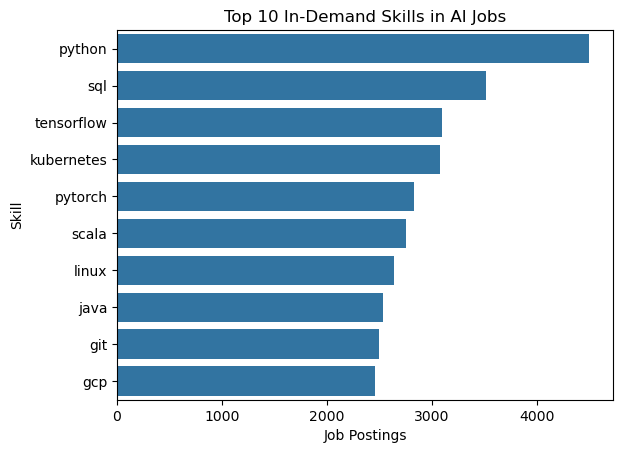

In [22]:
# Visualize the trend
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='count', y='skill', data=skill_counts.head(10))
plt.title('Top 10 In-Demand Skills in AI Jobs')
plt.xlabel('Job Postings')
plt.ylabel('Skill')
plt.show()

# Correlation with salary
skill_salary = df_exploded.groupby('required_skills').agg(
    avg_salary=('salary_usd', 'mean'),
    demand=('required_skills', 'count')
).sort_values(by='demand', ascending=False)

In [23]:
# Incorporate skill demand into the dashboard
skill_salary.to_sql('vw_skill_salary', engine, if_exists='replace', index=False)

24

In [24]:
# Improve skill demand visualization
df_exploded['required_skills'] = df_exploded['required_skills'].str.title()

skill_salary = df_exploded.groupby('required_skills').agg(
    avg_salary=('salary_usd','mean'),
    demand=('required_skills', 'count')
).reset_index()

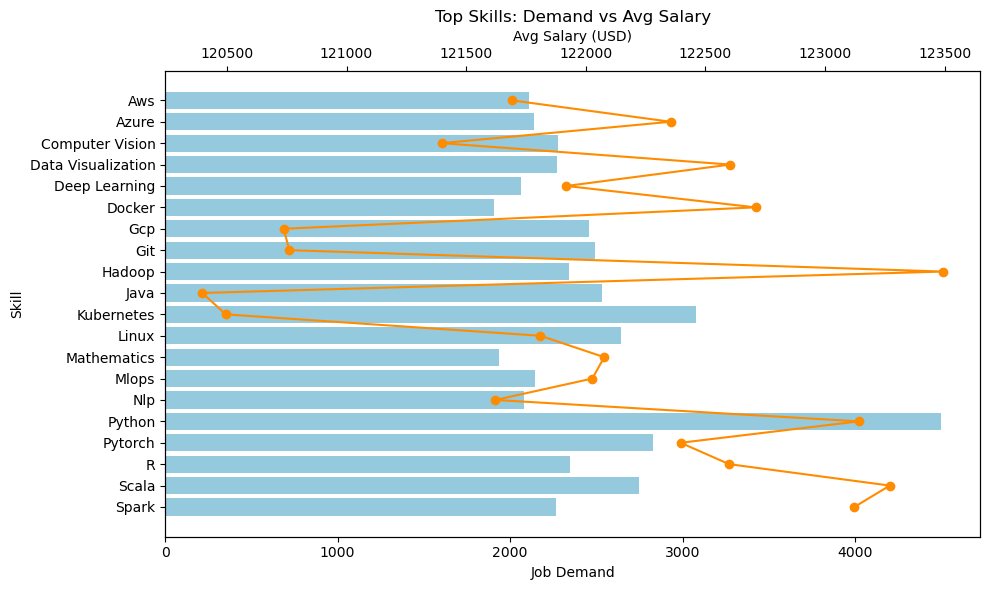

In [25]:
# Dual-axis chart

# Get top 20 skills by demand
top_skills = skill_salary.head(20)
fig, ax1 = plt.subplots(figsize=(10, 6))

# Barplot for demand
sns.barplot(x='demand', y='required_skills', data=top_skills, 
            ax=ax1, color='skyblue')
ax1.set_xlabel('Job Demand')
ax1.set_ylabel('Skill')
ax1.set_title('Top Skills: Demand vs Avg Salary')

# Line plot for salary overlay
ax2 = ax1.twiny()
ax2.plot(top_skills['avg_salary'], top_skills['required_skills'], 
         color='darkorange', marker='o')
ax2.set_xlabel('Avg Salary (USD)')

plt.tight_layout()
plt.show()

In [30]:
# Filter by role or location

df =pd.read_sql('SELECT required_skills, salary_usd, job_title, company_location FROM ai_jobs', engine)

# Explode skills
df['required_skills'] = df['required_skills'].str.lower().str.strip().str.split(', ')
df_exploded = df.explode('required_skills')
df_exploded['required_skills'] = df_exploded['required_skills'].str.strip().str.title()

# Push exploded dataframe to PostgreSQL as a new table
df_exploded.to_sql('ai_jobs_exploded', engine, if_exists='append', index=False)

# Grouped skill demand by role
role_skill_demand = df_exploded.groupby(['job_title', 'required_skills']).size().reset_index(name='demand')

# Skill heatmap by location
location_skill_demand = df_exploded.groupby(['company_location', 'required_skills']).size().reset_index(name='demand')

In [31]:
# Push view to PostgreSQL
skill_salary.to_sql('vw_skill_salary_overlay', engine, if_exists='replace', index=False)
role_skill_demand.to_sql('vw_role_skill_demand', engine, if_exists='replace', index=False)
location_skill_demand.to_sql('vw_location_skill_demand', engine, if_exists='replace', index=False)

ProgrammingError: (psycopg2.errors.WrongObjectType) "vw_location_skill_demand" is not a table
HINT:  Use DROP VIEW to remove a view.

[SQL: 
DROP TABLE vw_location_skill_demand]
(Background on this error at: https://sqlalche.me/e/20/f405)

In [34]:
# Load ai_jobs from PostgreSQL
df = pd.read_sql('SELECT job_title, company_location, experience_level, salary_usd FROM ai_jobs', engine)

# Create summary table
summary_table = df.groupby(['job_title', 'company_location', 'experience_level']).agg(
    avg_salary_usd=('salary_usd', 'mean'),
    job_count=('salary_usd', 'count')
).reset_index()

# Round salary for presentation
summary_table['avg_salary_usd'] = summary_table['avg_salary_usd'].round(2)

In [35]:
# Export key views to CSV
skill_salary.to_csv('skill_salary_overlay.csv', index=False)
role_skill_demand.to_csv('role_skill_demand.csv', index=False)
location_skill_demand.to_csv('location_skill_demand.csv', index=False)
summary_table.to_csv('role_location_summary.csv', index=False)

In [ ]:
# Done!